In [3]:
import urllib.request
import pickle, csv, json, os, re
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode, mean, median
from tqdm import tqdm
import requests

plt.rcParams["figure.figsize"] = (20,10)

# Data

We load in our stored local animes and mangas

In [4]:
import os
anime_dir_path = "data/animes/"

anime_dir = os.listdir(anime_dir_path)
all_animes = []
for file in anime_dir:
    with open(os.path.join(anime_dir_path, file),'r') as f:
        j = json.loads(f.read())
    all_animes.append(j)

In [5]:
all_anime_tv = [x for x in all_animes if x['type'] == 'TV']
print(len(all_anime_tv))
all_anime_tv = [x for x in all_anime_tv if x['score']]
print(len(all_anime_tv))
all_anime_tv = [x for x in all_anime_tv if x['synopsis']]
print(len(all_anime_tv))

8319
4320
4301


#### Data Structure

In [207]:
import pandas as pd

df = pd.DataFrame(all_anime_tv)

df = df.drop(["trailer","images","approved","url","titles","title_japanese",
"title_synonyms","type", "status", "aired", "broadcast", "producers", "background", 
"licensors","title_english", "explicit_genres"], axis='columns') #Uncertain if we should keep licensors
#df['genres'] = [re.sub(r'\b[^A-Z]*',' ',str(x)) for x in df['genres']]

def extractFromJsonToList(category):
    for mal_id in range(0,len(df.index)):
        items = []
        for item in range(0,len(df[category][mal_id])):
           items.append(df[category][mal_id][item]['name'])
        df[category][mal_id] = items

extractFromJsonToList('genres')
extractFromJsonToList('themes')
extractFromJsonToList('demographics')
extractFromJsonToList('studios')
print(print(df.columns))

<ipython-input-207-bf48e7307529>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category][mal_id] = items


Index(['mal_id', 'title', 'source', 'episodes', 'airing', 'duration', 'rating',
       'score', 'scored_by', 'rank', 'popularity', 'members', 'favorites',
       'synopsis', 'season', 'year', 'studios', 'genres', 'themes',
       'demographics'],
      dtype='object')
None


In [177]:
df

,mal_id,title,source,episodes,airing,duration,rating,score,scored_by,rank,popularity,members,favorites,synopsis,season,year,studios,genres,themes,demographics
0,5235,Live On Cardliver Kakeru,Manga,51.0,False,23 min per ep,PG - Children,6.38,256,7119,11675,1134,5,"Kakeru is a big fan of the Live On card game, ...",fall,2008.0,[TMS Entertainment],[Fantasy],[Strategy Game],[]
1,1735,Naruto: Shippuuden,Manga,500.0,False,23 min per ep,PG-13 - Teens 13 or older,8.25,1487306,283,16,2212915,102011,It has been two and a half years since Naruto ...,winter,2007.0,[Pierrot],"[Action, Adventure, Fantasy]",[Martial Arts],[Shounen]
2,2228,Honoo no Toukyuuji: Dodge Danpei,Manga,47.0,False,25 min per ep,PG - Children,7.30,2620,2496,7707,4893,25,Danpei Ichihgeki is the son of Daijurou Ichige...,fall,1991.0,[Animation 21],"[Comedy, Sports]","[School, Team Sports]",[Kids]
3,3136,Ochamegami Monogatari: Korokoro Pollon,Manga,46.0,False,22 min per ep,G - All Ages,6.93,1375,4263,9171,2887,7,Anime about the funny lives of the Greek gods ...,spring,1982.0,[Kokusai Eigasha],[Comedy],[Parody],[]
4,1721,Hitohira,Manga,12.0,False,23 min per ep,PG-13 - Teens 13 or older,6.75,7396,5097,4422,19448,30,A transfer student Asai Mugi is a painfully sh...,spring,2007.0,[XEBEC M2],"[Drama, Romance, Slice of Life]","[Performing Arts, School]",[Seinen]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,2225,Alps no Shoujo Heidi,Book,52.0,False,25 min per ep,PG - Children,7.34,17656,2316,3411,33674,287,"After becoming an orphan, Heidi is forced to l...",winter,1974.0,[Nippon Animation],[Drama],[Historical],[]
4297,12175,Koi to Senkyo to Chocolate,Visual novel,12.0,False,25 min per ep,PG-13 - Teens 13 or older,7.01,97362,3926,897,231353,446,Yuuki Oojima is a member of his high school's ...,summer,2012.0,[AIC Build],"[Drama, Romance]",[School],[]
4298,2543,Robin Hood no Daibouken,Unknown,52.0,False,25 min per ep,G - All Ages,7.09,3803,3569,6259,8149,29,A variant of Robin Hood in which all the princ...,summer,1990.0,[Tatsunoko Production],"[Adventure, Romance]",[Historical],[]
4299,3885,Sugar Bunnies,Unknown,26.0,False,11 min per ep,G - All Ages,5.94,153,9465,12097,971,2,Random cutesy edutainment tales aimed at small...,spring,2007.0,[Asahi Production],[],[],[Kids]


In [6]:
all_anime_tv_id = [anime['mal_id'] for anime in all_anime_tv]
anime_graph = nx.Graph()
anime_graph.add_nodes_from(all_anime_tv_id)

fh = open("data/edgeanimelist.txt", 'r') 
anime_edge_graph = nx.read_weighted_edgelist(fh, nodetype = int)

anime_graph.add_edges_from(anime_edge_graph.edges(data = True))
print(len(anime_graph))
# anime_graph = nx.read_weighted_edgelist("data/edgeanimelist.txt")

4301


In [213]:
recommendations = [degree for _, degree in anime_graph.degree]
df['recommendations'] = recommendations

                    score   members  favorites  recommendations  episodes  \
score            1.000000  0.464375   0.342202         0.460049 -0.032891   
members          0.464375  1.000000   0.776820         0.699449 -0.029849   
favorites        0.342202  0.776820   1.000000         0.596950  0.024883   
recommendations  0.460049  0.699449   0.596950         1.000000 -0.026743   
episodes        -0.032891 -0.029849   0.024883        -0.026743  1.000000   
rank            -0.976225 -0.409823  -0.263029        -0.442601  0.041231   
scored_by        0.420340  0.989032   0.782911         0.648800 -0.019482   
popularity      -0.577295 -0.479815  -0.236168        -0.506101  0.166285   

                     rank  scored_by  popularity  
score           -0.976225   0.420340   -0.577295  
members         -0.409823   0.989032   -0.479815  
favorites       -0.263029   0.782911   -0.236168  
recommendations -0.442601   0.648800   -0.506101  
episodes         0.041231  -0.019482    0.166285  


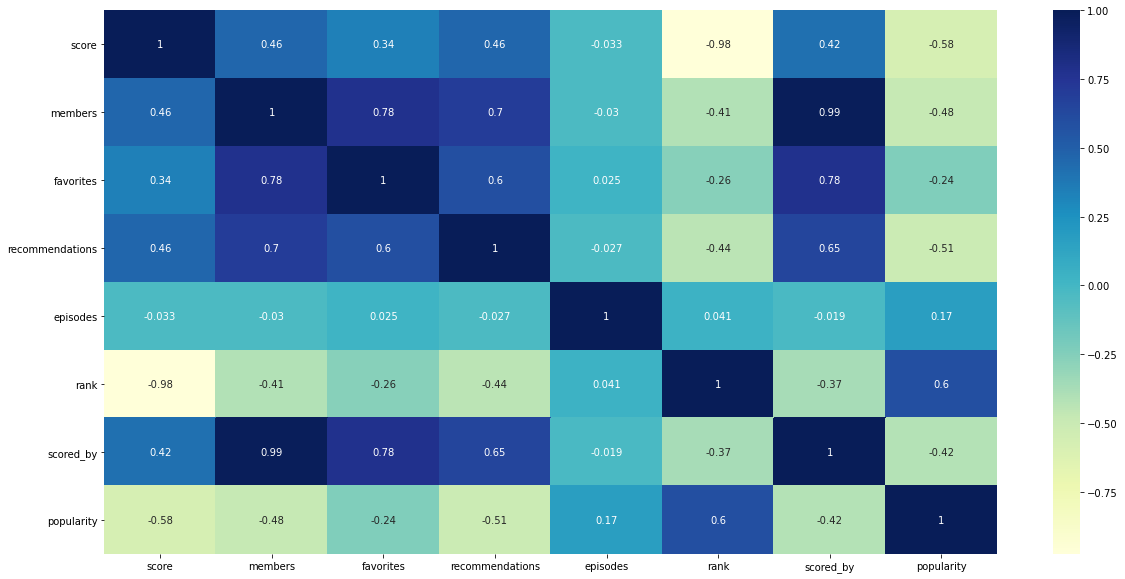

In [216]:
import seaborn as sb


# prints data that will be plotted for the correlation matrix
print(df[['score','members','favorites','recommendations', 'episodes','rank','scored_by','popularity']].corr())
  
# plot correlation heatmap
dataplot = sb.heatmap(df[['score','members','favorites','recommendations', 'episodes','rank','scored_by','popularity']].corr(), cmap="YlGnBu", annot=True)
plt.show()

In [176]:
# Since we have a lot of nodes without recommendations, it is best to find the GCC of our graph
GCC = max(nx.connected_components(anime_graph), key=len)
anime_GCC = anime_graph.subgraph(GCC).copy()
print(anime_GCC)

In [8]:
def get_degree_properties(graph):
    out_degrees = []
    prop = {}
    prop['out'] = {}
    prop['in'] = {}
    
    for _ , d in graph.degree():
        out_degrees.append(d)
        
    prop['outdegrees'] = out_degrees

    
    prop['out']['max'] = max(out_degrees)

    
    prop['out']['min'] = min(out_degrees)

    
    prop['out']['avg'] = mean(out_degrees)

    
    prop['out']['median'] = median(out_degrees)

    
    prop['out']['mode'] = mode(out_degrees)

    
    return prop

properties = get_degree_properties(anime_GCC)
print("Out:",properties['out'])
print("In:",properties['in'])

Out: {'max': 245, 'min': 1, 'avg': 20.13478634929739, 'median': 11, 'mode': 1}
In: {}


In [9]:

# Overall
sorted_popular_anime = sorted(anime_GCC.degree, key=lambda x: x[1], reverse=True)[0:5]
sorted_popular_anime = [(int(x),y) for (x,y) in sorted_popular_anime]

sorted_popular_anime = [(anime['titles'][0]['title'], count) for (id, count) in sorted_popular_anime for anime in all_anime_tv if id == anime['mal_id']]
print(sorted_popular_anime)

[('Mahou Shoujo Madoka★Magica', 245), ('Code Geass: Hangyaku no Lelouch', 236), ('Neon Genesis Evangelion', 232), ('Gintama', 207), ('Tengen Toppa Gurren Lagann', 193)]


In [10]:
C_anime_full = [(k, v) for k, v in nx.degree_centrality(anime_GCC).items()]

C_anime_v = [v for k, v in nx.degree_centrality(anime_GCC).items()]
print("avg anime degree centrality:",mean(C_anime_v))

avg anime degree centrality: 0.005775899698593628


In [11]:
import random
def shuffle_network(graph):
    # create a random mapping old label -> new label
    node_mapping = dict(zip(graph.nodes(), sorted(graph.nodes(), key=lambda k: random.random())))
    # build a new graph
    R = nx.relabel_nodes(graph, node_mapping)
    
    return R

In [12]:
R = shuffle_network(anime_GCC)

print(R)

In [13]:
R_anime_C = []

for i in range(1000):
    R = shuffle_network(anime_GCC)
    #Rs.append(R)
    C_anime_v = [v for k, v in nx.degree_centrality(R).items()]
    R_anime_C.append(mean(C_anime_v))

# Community Detection

In [14]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import re
import nltk
import matplotlib.pyplot as plt

In [15]:
# Lemmatization of lists
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def lemmatizeList(list):
    lemma_list = []
    for word, tag in pos_tag(list):
        lemma = WordNetLemmatizer().lemmatize(word, tag_map[tag[0]])
        lemma_list.append(lemma)
    return lemma_list

In [16]:
def text_processing(partition, community_list):

    corpus = []
    for i in community_list:
        anime_community_ids = [key for key, value in partition.items() if value == i]
        text = ""
        # Loop through all the anime and find the one that are within the community, add text
        for anime in all_anime_tv:        
            if (anime['mal_id'] in anime_community_ids):
                end = -1
                try:
                    end = re.search("(\[Written by.*]|\(Source:.*\))",anime['synopsis']).span()[0] 
                except AttributeError:
                    pass
                
                text += anime['synopsis'][:end]
                
                # Only for anime id 5725 makes the change of word from cards to card, which does not influence
                # The end result, therefore end will be -1, in case the synopsis doesn't state the source
                if(anime['synopsis'][end].isalpha()): 
                    print(anime['mal_id'])
                
        tokens = word_tokenize(re.sub("[^0-9a-zA-Z\s]+","",text))

        # Process each document of the text of a community through lemmatization, remove stop words and only take words/numbers.
        stop_words = stopwords.words('english')

        processed_text_1 = lemmatizeList([w.lower() for w in tokens])
        processed_text_2 = [w for w in processed_text_1 if not w in stop_words]
        corpus.append(processed_text_2)

    return corpus

#### To ensure we find the same communities each time, random seed will be used

In [17]:
import random
import sys

# create a seed
seed_value = random.randrange(sys.maxsize)
# save this seed somewhere. So if you like the result you can use this seed to reproduce it
print('Seed value:', seed_value)
# Output 5329025261059076053

# Now, Seed the random number generator
random.seed(2870151239873871873)

Seed value: 5816336868246682736


In [18]:
import networkx.algorithms.community as nx_com
import community

#Find the best partition for each universe - using the louvain algorithm
anime_partition = community.best_partition(anime_GCC, weight = 'weight')

In [19]:
len(anime_GCC)

3487

In [20]:
anime_partition_values = [anime_partition.get(node) for node in anime_GCC.nodes()]

In [21]:
anime_communities = {}
anime_communities2 = {}

for key in anime_partition_values:
    if key in anime_communities:
        anime_communities[key] += 1
    else:
        anime_communities[key] = 1

print("The anime network partition consists of", len(anime_communities), "communities and the sizes of the communities are", list(anime_communities.values()))

The anime network partition consists of 12 communities and the sizes of the communities are [137, 381, 294, 219, 628, 425, 315, 333, 150, 299, 208, 98]


In [22]:
community.modularity(anime_partition,anime_GCC, weight = 'weight')

0.5186246596829879

#### Visualize the communities by coloring the graph's nodes according to community affiliation

In [23]:
import matplotlib.colors as colors
import fa2

def fa_community_plot(graph, partition):  
    forceatlas2 = fa2.ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=0.5,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=1.0,
                            strongGravityMode=True,
                            gravity=1.0,

                            # Log
                            verbose=False)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=1000)
    nx.draw_networkx_edges(graph, positions, edge_color="yellow", alpha=0.2)
    #Count is used to give each community their own color
    count = 0
    #Go through each community and draw all the nodes in the same color
    for com in set(partition.values()) :
        count = count + 1
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        color = list(colors.cnames.keys())[count]
        nx.draw_networkx_nodes(graph, positions, list_nodes, node_size = 100, node_color = str(color), alpha=1)
    plt.axis('off')
    plt.show()

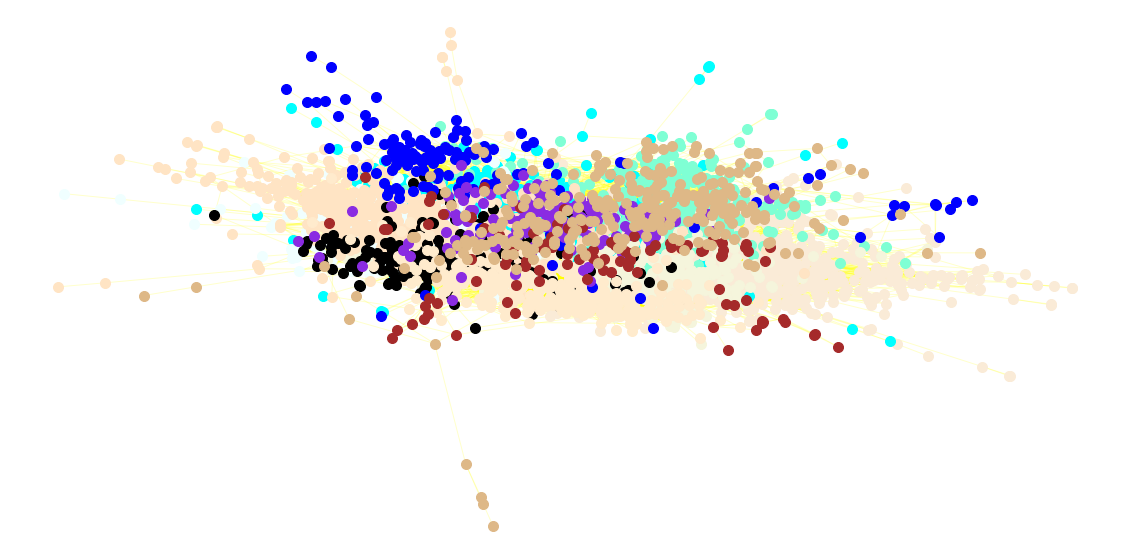

In [24]:
fa_community_plot(anime_GCC, anime_partition)

In [25]:
anime_freq = nltk.FreqDist(anime_partition_values)
anime_freq

FreqDist({0: 628, 5: 425, 1: 381, 7: 333, 4: 315, 11: 299, 2: 294, 3: 219, 6: 208, 9: 150, ...})

In [26]:
# Based on what we know of the sizes of each community, it is probably only interesting to look at the 12 biggest communities.
anime_corpus = text_processing(anime_partition, list(anime_freq))

5725


In [27]:
# A list of all the tf list from each community
community_list_freq= []

for i, community_text in zip(list(anime_freq), anime_corpus):
    
    # To have the term frequency in count
    term_freqdist = nltk.FreqDist(community_text)

    # To have the term frequency in count / N format, which is the tf-format of the example from the wikipage of TF-IDF
    total = term_freqdist.N()
    for word in term_freqdist:
        term_freqdist[word] /= float(total)
    
    # Add every term frequency distribution for a community in our list
    community_list_freq.append(term_freqdist)

    # Printing out the top 5 terms of each community (percentage)
    print("Community " + str(i) + " has " + str(anime_freq[i]) + " anime and has these top 5 terms according to TF:")
    print(term_freqdist.most_common(5))

Community 0 has 628 anime and has these top 5 terms according to TF:
[('school', 0.010859456206575852), ('girl', 0.008370260955194485), ('life', 0.006893156080748399), ('new', 0.005908419497784343), ('friend', 0.005716942939985776)]
Community 5 has 425 anime and has these top 5 terms according to TF:
[('earth', 0.007354345749761223), ('world', 0.006399235912129895), ('one', 0.0054441260744985676), ('know', 0.005380452085323145), ('year', 0.004934734161095192)]
Community 1 has 381 anime and has these top 5 terms according to TF:
[('world', 0.007535741953658709), ('one', 0.006761039509824636), ('however', 0.005387703359391507), ('become', 0.00521163462215649), ('life', 0.00510599337981548)]
Community 7 has 333 anime and has these top 5 terms according to TF:
[('school', 0.010388627187079408), ('girl', 0.01034656796769852), ('one', 0.006855652759084791), ('life', 0.006855652759084791), ('student', 0.006098586810228802)]
Community 4 has 315 anime and has these top 5 terms according to TF:


In [28]:
# In this code section, we want to calculate the IDF of every word from the whole anime_corpus
idf_list = []
# Extract all words from the whole anime_corpus
anime_words = [item for document in anime_corpus for item in document]

# Check amount of occurence of a word
for word in set(anime_words):
    occurences = 0

    # Check if the word occurs on each community text. Max occurence is the total amount of text documents of the corpus
    for community_text in anime_corpus:
        if word in community_text:
            occurences += 1
    
    # Calculate the inverse document frequency
    idf = np.log(len(anime_corpus)/occurences)
    idf_list.append((word,idf))

# Convert the list of tuples to a dictionary, which we will use later
idf_dict = dict(idf_list)

In [29]:
idf_list

[('central', 0.6931471805599453),
 ('x23', 2.4849066497880004),
 ('game', 0.0870113769896297),
 ('folk', 0.5389965007326869),
 ('1991', 2.4849066497880004),
 ('trajectory', 2.4849066497880004),
 ('enslave', 1.3862943611198906),
 ('igura', 2.4849066497880004),
 ('ponder', 0.8754687373538999),
 ('winford', 2.4849066497880004),
 ('sojiro', 2.4849066497880004),
 ('jaq', 2.4849066497880004),
 ('jerrard', 2.4849066497880004),
 ('keina', 2.4849066497880004),
 ('laterand', 2.4849066497880004),
 ('disabled', 2.4849066497880004),
 ('consequently', 0.4054651081081644),
 ('arte', 2.4849066497880004),
 ('yuuichi', 1.791759469228055),
 ('sera', 2.4849066497880004),
 ('artes', 2.4849066497880004),
 ('break', 0.0),
 ('zara', 2.4849066497880004),
 ('councila', 2.4849066497880004),
 ('usagiyama', 2.4849066497880004),
 ('cavernous', 2.4849066497880004),
 ('doraemon', 1.791759469228055),
 ('girlfriend', 0.0870113769896297),
 ('daruku', 2.4849066497880004),
 ('dirty', 0.5389965007326869),
 ('norois', 2.484

In [30]:
# A list of all the tf-idf list from each community
community_list_tf_idf = []

for term_freqdist in community_list_freq:
    community_tf_idf = nltk.FreqDist(term_freqdist) # Copies values and ensures that we don't overwrite tf distribution

    for word in community_tf_idf:

        # Get the idf of the word from the idf dictionary we made previously
        idf = idf_dict[word]

        # tf-idf is calculated by the tf of a word within the document and the idf of the word of the document set (our corpus)
        community_tf_idf[word] = (dict(term_freqdist)[word] * idf)

    community_list_tf_idf.append(community_tf_idf)

In [31]:
# Listing the 10 top words for each community accourding to TF-IDF
for i, tf_idf in zip(list(anime_freq),community_list_tf_idf):
    print("The top 10 term according to TF-IDF for community " + str(i) + ":")
    print(tf_idf.most_common(10))

The top 10 term according to TF-IDF for community 0:
[('prism', 0.001176274064814085), ('bread', 0.0006797162453602496), ('idol', 0.0006583085917392091), ('gintoki', 0.0006371484517742961), ('yorozuya', 0.0005881370324070425), ('ika', 0.0005437729962881997), ('chef', 0.0005409218555726784), ('kana', 0.000539125613039789), ('waitress', 0.0005308857447255996), ('hina', 0.00048081942717571413)]
The top 10 term according to TF-IDF for community 5:
[('colony', 0.0015329761399065422), ('squadron', 0.0012549732035344542), ('titan', 0.0010492954046495795), ('eren', 0.0008556635478644007), ('gundam', 0.000769483296743025), ('space', 0.000719766731692148), ('railway', 0.000712007636042407), ('abh', 0.000712007636042407), ('galactic', 0.0006620316910792218), ('aircraft', 0.0006328956764821396)]
The top 10 term according to TF-IDF for community 1:
[('gokuu', 0.0014000460031202199), ('naruto', 0.0009625316271451512), ('ninku', 0.0008750287519501375), ('manta', 0.0007875258767551237), ('izuku', 0.00

In [32]:
# Function to make wordclouds with titles
from wordcloud import WordCloud
def make_word_cloud(tf_idf, community_number):

    # To make this work check: https://stackoverflow.com/questions/47298070/importerror-no-module-named-wordcloud
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(tf_idf) 
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Community " + str(community_number))
    plt.show()

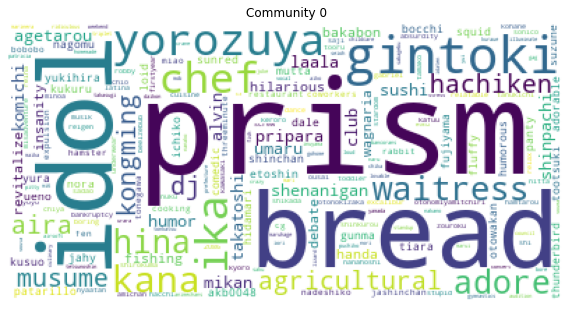

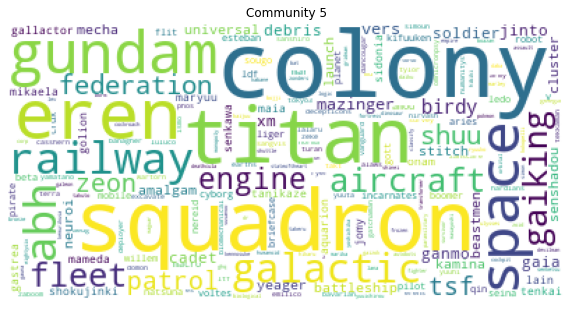

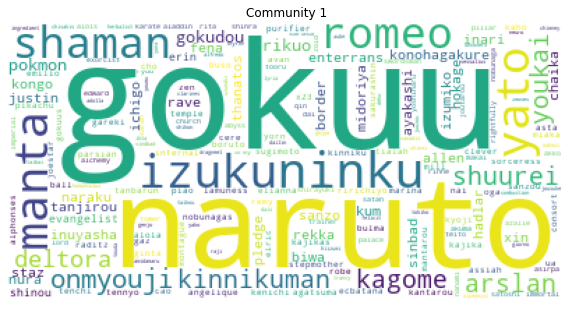

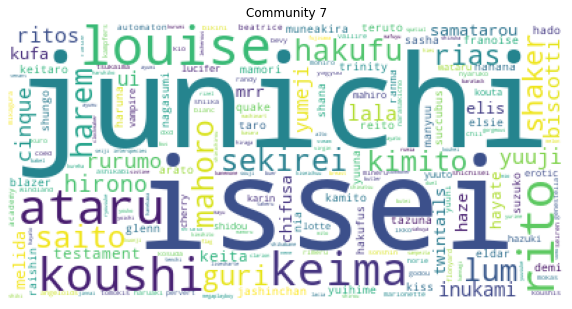

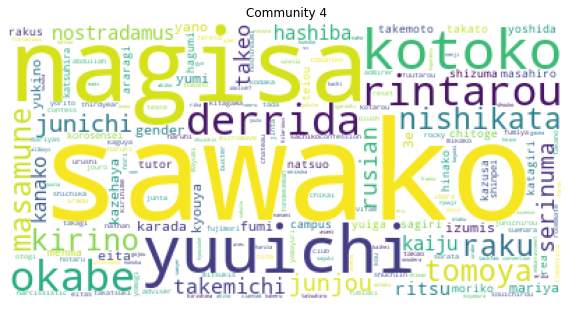

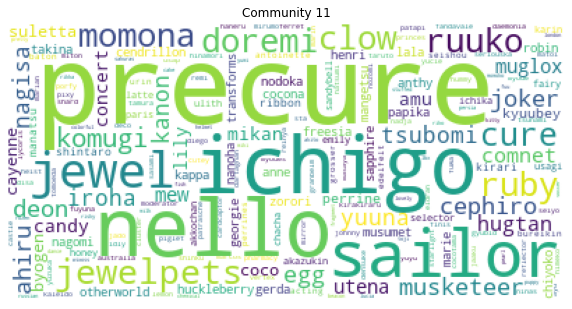

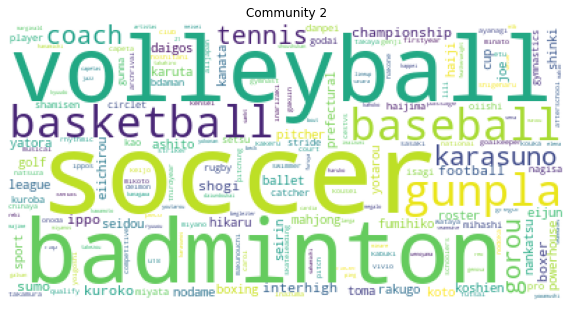

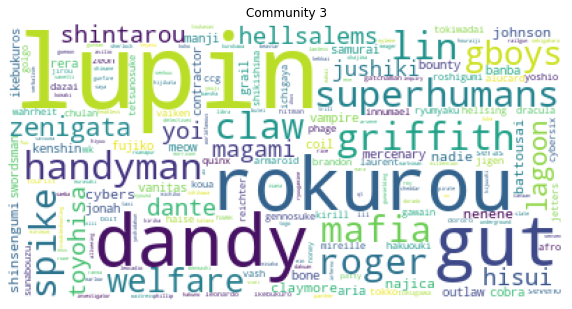

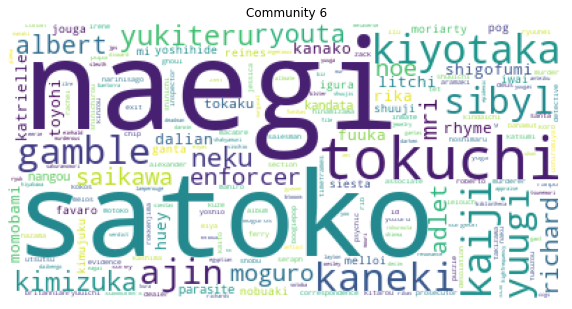

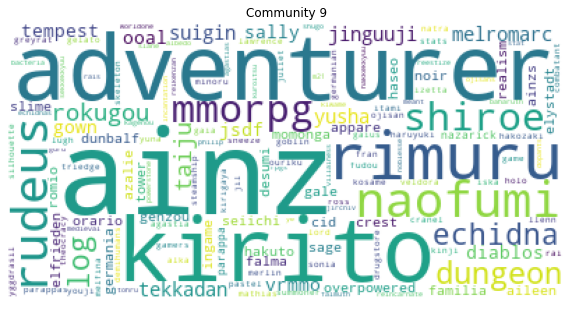

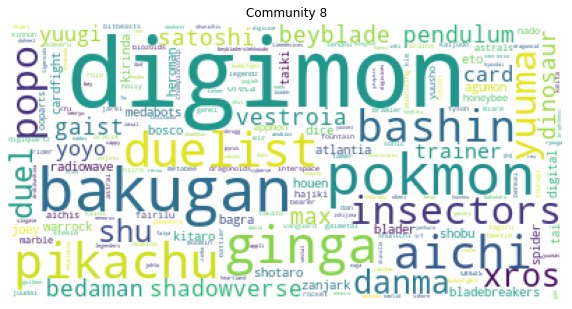

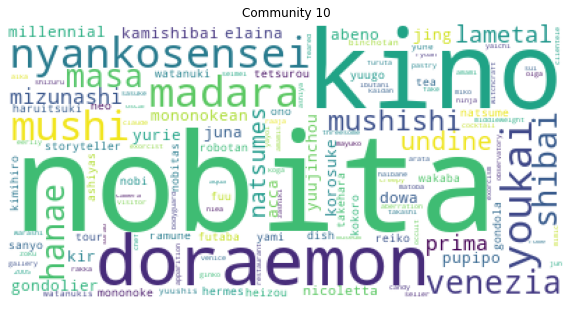

In [33]:
# Create word clouds for each DC community
for i, tf_idf in zip(list(anime_freq),community_list_tf_idf):
    make_word_cloud(dict(tf_idf),i)

**** 

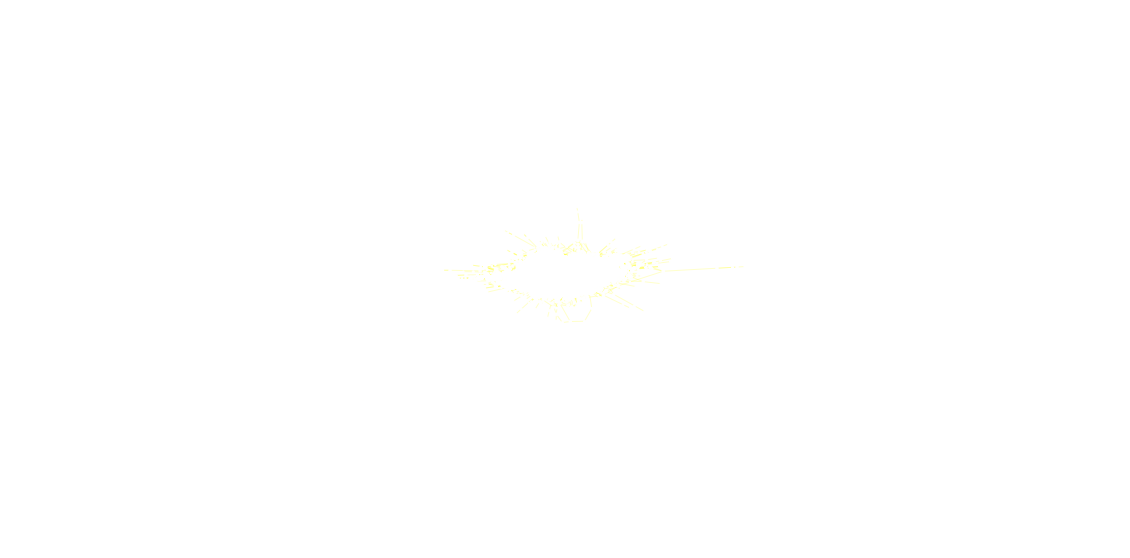

In [34]:
import fa2
d = dict(anime_graph.degree)
def fa_plot(graph,d,node_scale):
    color_map = []

    # for n in graph.nodes:
    #     if 'attr' in graph.nodes[n]:
    #         t = graph.nodes[n]['attr']['team']
    #         if t == 'dc':
    #             color_map.append("#ff0000")
    #         elif t =='marvel':
    #             color_map.append("#A0CBE2")
    #     else:
    #         color_map.append("#000000")
            
    forceatlas2 = fa2.ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=0.5,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=False)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=500)
    nx.draw_networkx_edges(graph, positions, edge_color="yellow", alpha=0.2)
    nx.draw_networkx_nodes(graph, positions, node_size=[v * node_scale for v in d.values()], alpha=1, node_color='w')
    #Give the nodes their correct color
    nx.draw_networkx_nodes(graph, positions, node_color=color_map, node_size=[v * node_scale for v in d.values()], alpha=0.7)
    plt.axis('off')
    plt.show()
    
fa_plot(anime_graph,d,2)

# Sentiment

First we get the synopsis of each anime tv show, and store it in a seperate text file.

In [36]:
import os
path = os.path.join("data","synopsis")
os.makedirs(path)

In [37]:
for anime in all_anime_tv:
    file_name = "{}.txt".format(anime['mal_id'])
    write_file = open("data/synopsis/"+file_name, "w")
    write_file.write(json.dumps(anime['synopsis']))
    write_file.close()

Tokenize the synopsis, and remove stop words.

In [38]:
from bs4 import BeautifulSoup
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
#The root is the directory
corpus_root_dc = r"data/synopsis" 
file_pattern = r".*\.txt"
ptb_dc = PlaintextCorpusReader(corpus_root_dc, file_pattern)
xx = 0
token_dict = {}
for fileid in ptb_dc.fileids():
    raw = ptb_dc.raw(fileids=fileid)
    #raw = BeautifulSoup(html, 'html.parser').get_text()
    try: 
        start = re.search('\"',raw).span()[1]
    except AttributeError:
        print("error")
    tokens = word_tokenize(raw[start:])
    token_dict[fileid.split('.txt')[0]] = [w.lower() for w in tokens if w.isalpha()]

stop_words = stopwords.words('english')

for k,v in token_dict.items(): #remove stop words from token_dict for later sentiment use
    token_dict[k] = [w for w in v if w not in stop_words]

Store the average happiness score of words:

In [39]:
class Word:
    def __init__(self,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank):
        self.word = word
        self.happiness_average = float(happiness_average)

labMIT = {}
with open("labMIT.txt") as f:
    for line in f:
       (word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank) = line.split()
       labMIT[word] = Word(word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank)


We create a function that can calculate the sentiment of a given tokenlist

In [40]:
def get_sentiment(tokenlist):
    sentiment = 0
    num_of_tokens = len(tokenlist)
    if num_of_tokens == 0:
        print('input tokenlist was empty')
        num_of_tokens = 1
    
    for w in tokenlist:
        try: 
            sentiment = sentiment + (labMIT[str(w)].happiness_average)
        except KeyError:
            if num_of_tokens > 1:
                num_of_tokens = num_of_tokens-1
                
    sentiment = sentiment/num_of_tokens
    return sentiment

We can now calculate the sentiment of all the synopsis

In [41]:
fails = 0
sentiments = []
for mal_id in anime_graph.nodes:
    try:
        s = get_sentiment(token_dict[str(mal_id)])
        anime_graph.nodes[mal_id]['Sentiment'] = s
        if s != 0: #We dont consider pages with sentiment 0, as these contain no words in our sentiment library.
            sentiments.append(s)
    except KeyError:
        fails = fails + 1

#print(fails,"nodes could not have their sentiment calculated")

We define a couple of functions for plotting pretty histograms along with their mean, as well as 10th and 90th percentile.

The functions: outlier_aware_sentiment_hist, mad, calculate_bounds is a modified version of the code posted by user Benjamin Doughty in the stackoverflow thread [Making pyplot.hist() first and last bins include outliers](https://stackoverflow.com/questions/15837810/making-pyplot-hist-first-and-last-bins-include-outliers)

In [42]:
def outlier_aware_sentiment_hist(data,mean,tenth,ninetieth,t,sent=False,lower=None, upper=None):
    if not lower or lower < min(data):
        lower = min(data)
        lower_outliers = False
    else:
        lower_outliers = True

    if not upper or upper > max(data):
        upper = max(data)
        upper_outliers = False
    else:
        upper_outliers = True

    n, bins, patches = plt.hist(data, range=(lower, upper), bins='auto',edgecolor='black')

    if lower_outliers:
        n_lower_outliers = sum(data < lower)
        patches[0].set_height(patches[0].get_height() + n_lower_outliers)
        patches[0].set_facecolor('c')
        patches[0].set_label('Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower))

    if upper_outliers:
        n_upper_outliers = sum(data > upper)
        patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
        patches[-1].set_facecolor('m')
        patches[-1].set_label('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data)))
    if sent:
        plt.plot([mean,mean],[0,max(n)*1.02],linewidth=5)
        plt.plot([tenth,tenth],[0,max(n)*1.02],linewidth=5)
        plt.plot([ninetieth,ninetieth],[0,max(n)*1.02],linewidth=5)
        plt.legend(['Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower),('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data))),('Distribution Mean: {:.2f}'.format(mean)),('10th percentile: {:.2f}'.format(tenth)),'90th percentile: {:.2f}'.format(ninetieth)])
        plt.xlabel('Sentiment value')
        plt.ylabel('Count')
    else:
        plt.legend()
    plt.title(t)
        
def mad(data):
    median = np.median(data)
    diff = np.abs(data - median)
    mad = np.median(diff)
    return mad

def calculate_bounds(data, z_thresh=3.5):
    MAD = mad(data)
    median = np.median(data)
    const = z_thresh * MAD / 0.6745
    return (median - const, median + const)

def sentiment_stats_and_hist(sents,t):
    sent_mean = mean(sents)
    tenth = np.percentile(sents,10)
    ninetieth = np.percentile(sents,90)
    print("Sentiment mean:",sent_mean)
    print("tenth percentile:",tenth)
    print("ninetieth percentile:",ninetieth)
    outlier_aware_sentiment_hist(sents,sent_mean,tenth,ninetieth,t,True,*calculate_bounds(sents))


Sentiment mean: 5.716140110765166
tenth percentile: 5.354153846153846
ninetieth percentile: 6.068976623376623


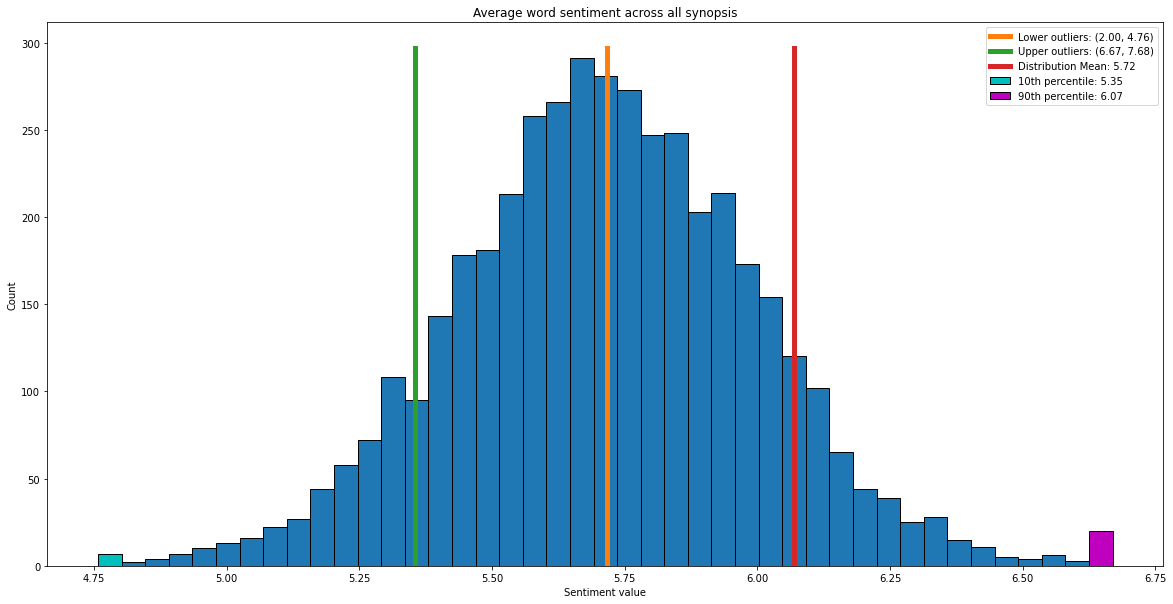

In [43]:
sentiment_stats_and_hist(sentiments,'Average word sentiment across all synopsis')

# Next steps

Split datasettet op i nogle kategorier og sammenlign?<br>F.eks. høj rating vs lav rating? men hvor er cut offet?<br>
Evt. gradierer farven på noderne i plottet alt efter rating? hvis det er muligt, kunne være blæret.<br>
Evt. et møde med sune for at høre hvad der giver mening.